CDAE Simulation #1: Scipy Signal
==================

Reference implementation of CDAE using floating point arithmetic and `scipy.signal`.

In [1]:
%pylab inline --no-import-all
from fast_multiphase_avg import *
from scipy.signal import *
from scipy.interpolate import interp1d

if True:
    RAW_S = np.loadtxt("cdae_demo_s.txt")
    S = np.zeros((RAW_S.shape[0], RAW_S.shape[1] + 20))
    S[:, 20:] = RAW_S
    for i in range(20):
        S[:,i] = RAW_S[:,0]
    P = np.loadtxt("cdae_demo_p.txt") + 20
    x_frm, x_to = np.mean(P) - 5, np.mean(P) + 5
    P -= np.mean(P)

else:
    P = np.random.uniform(size=500)
    S = np.array([1000 * np.exp(-(np.arange(100) - P[i] - 50)**2) for i in range(P.shape[0])])
    S = np.round(S + 200 + 1.5 * np.random.normal(size=S.shape))
    x_frm, x_to = 45, 55

# M ... number of shots
# N ... number of samples per shot
M, N = S.shape

# stddev of zero drift
zero_drift_std = 0.1

Populating the interactive namespace from numpy and matplotlib


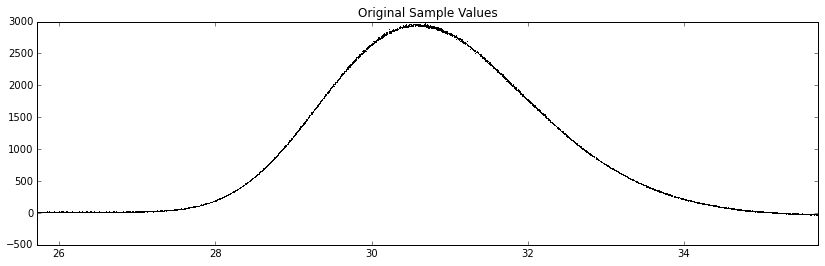

In [2]:
plt.figure(figsize=(14, 4))
for i in range(500):
    plt.plot(np.arange(N)-P[i], S[i,:], 'k,')
plt.title("Original Sample Values")
plt.xlim(x_frm, x_to);

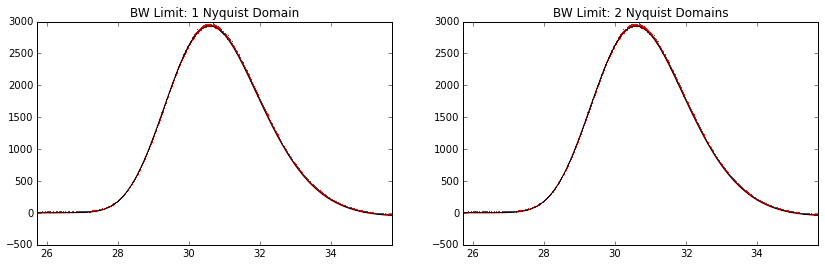

In [3]:
plt.figure(figsize=(14, 4))

# BW-Limited to 1 nyquist domain

fine_x, fine_y = fast_multiphase_avg(S, -P, 8, 1)

plt.subplot(1, 2, 1)
for i in range(500):
    plt.plot(np.arange(N)-P[i], S[i,:], 'r,')
plt.plot(fine_x, fine_y, 'k')
plt.title("BW Limit: 1 Nyquist Domain")
plt.xlim(x_frm, x_to);

# BW-Limited to 2 nyquist domains

fine_x, fine_y = fast_multiphase_avg(S, -P, 8, 2)

plt.subplot(1, 2, 2)
for i in range(500):
    plt.plot(np.arange(N)-P[i], S[i,:], 'r,')
plt.plot(fine_x, fine_y, 'k')
plt.title("BW Limit: 2 Nyquist Domains");
plt.xlim(x_frm, x_to);

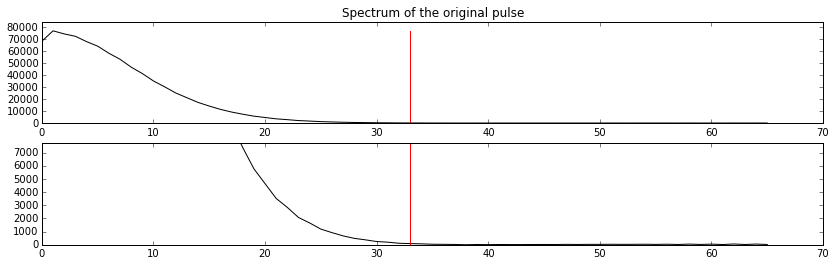

In [4]:
spectrum = np.abs(np.fft.rfft(fine_y))[:N]

plt.figure(figsize=(14, 4))

plt.subplot(2, 1, 1)
plt.plot(spectrum, 'k')
plt.plot([N/2, N/2], [np.max(spectrum), 0], 'r')
plt.ylim(0, np.max(spectrum[1:]) * 1.1)
plt.title("Spectrum of the original pulse")

plt.subplot(2, 1, 2)
plt.plot(spectrum, 'k')
plt.plot([N/2, N/2], [np.max(spectrum), 0], 'r')
plt.ylim(0, np.max(spectrum[1:]) * 0.1);

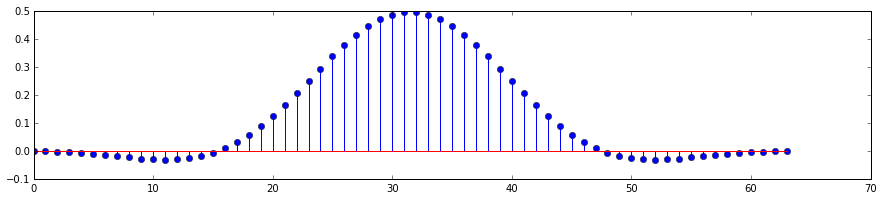

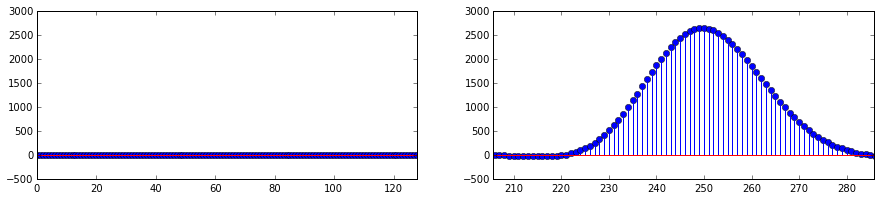

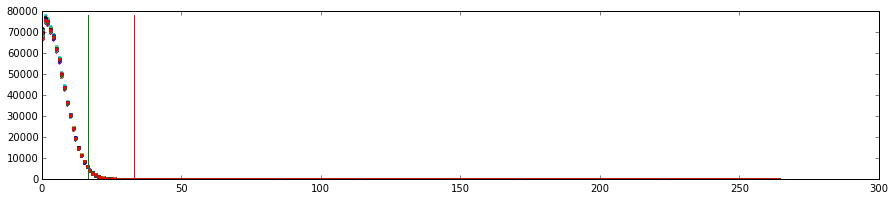

In [5]:
# Oversampling and filtering
oversampling = 8

# oversampled, zero-padded version of the signal
INTERP_S = np.zeros((M, oversampling*N))
for i in range(M):
    INTERP_S[i, ::oversampling] = S[i,:] - S[i, 0]

# FIR interpolation filter
fir_h = firwin(64, 0.5 / oversampling) * oversampling
INTERP_S = lfilter(fir_h, [1.0], INTERP_S, axis=1)
INTERP_S = np.roll(INTERP_S, -len(fir_h)//2, axis=1)

plt.figure(figsize=(15,3))
plt.stem(fir_h)

plt.figure(figsize=(15,3))
plt.subplot(1, 2, 1)
plt.stem(INTERP_S[22,:])
plt.xlim(0, 2*len(fir_h))
plt.subplot(1, 2, 2)
plt.stem(INTERP_S[22,:])
plt.xlim(x_frm * oversampling, x_to * oversampling)

plt.figure(figsize=(15,3))
SPECTR = np.abs(np.fft.rfft(INTERP_S, axis=1))
plt.plot(SPECTR.T, ".")
plt.plot([N/2, N/2], [0, np.max(SPECTR)], "r-")
plt.plot([N/4, N/4], [0, np.max(SPECTR)], "g-");

sos [0]:    1.3599e-04   2.7199e-04   1.3599e-04   1.0000e+00  -1.9228e+00   9.2874e-01
sos [1]:    1.0000e+00   0.0000e+00  -1.0000e+00   1.0000e+00  -1.9172e+00   9.4232e-01
sos [2]:    1.0000e+00  -2.0000e+00   1.0000e+00   1.0000e+00  -1.9844e+00   9.8588e-01
System gain: 1.359932e-04


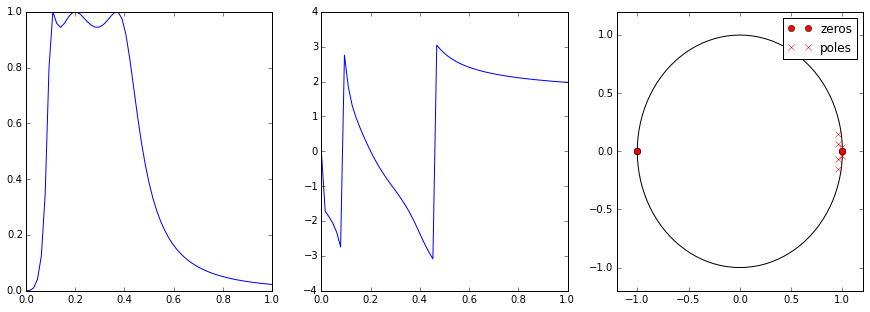

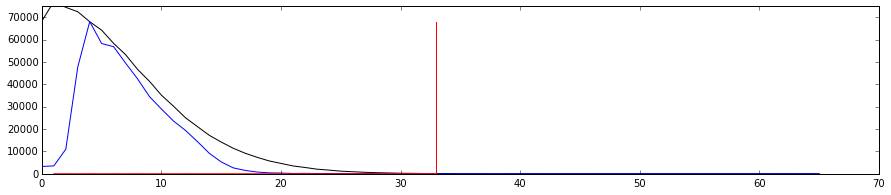

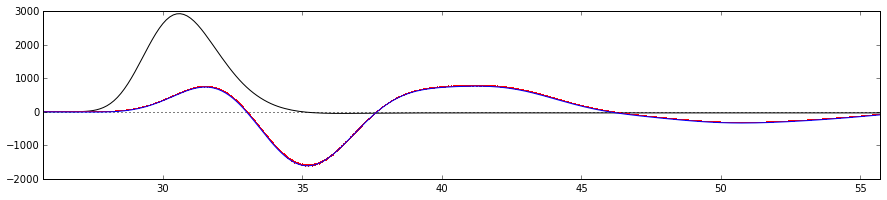

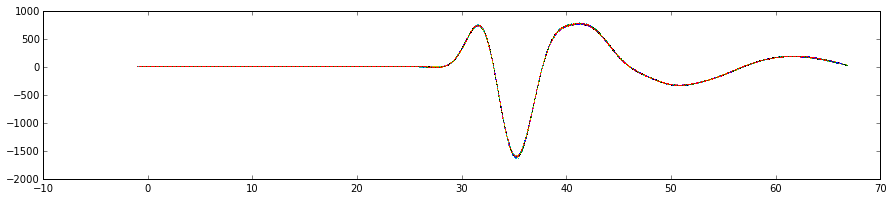

In [6]:
# chebyshev bandpass, cutoff at 0.1x and 0.4x nyquist frequency
# iir_b, iir_a = cheby1(3, 0.5, [0.1 / oversampling, 0.4 / oversampling], btype='bandpass')
iir_sos = cheby1(3, 0.5, [0.1 / oversampling, 0.4 / oversampling], btype='bandpass', output='sos')

for i in range(iir_sos.shape[0]):
    print("sos [%d]:  %s" % (i, " ".join(["%12.4e" % v for v in iir_sos[i,:]])))

b, a = sos2tf(iir_sos)
w, h = freqz(b, a)
z, p, k = tf2zpk(b, a)

print("System gain: %e" % k)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(w * oversampling / np.pi, np.abs(h))
plt.xlim(0, 1)

plt.subplot(1, 3, 2)
plt.plot(w * oversampling / np.pi, np.angle(h));
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
unit_circle = np.exp(2j*np.pi*np.arange(101)/100)
plt.plot(np.real(unit_circle), np.imag(unit_circle), "k")
plt.plot(np.real(z), np.imag(z), "ro", label="zeros")
plt.plot(np.real(p), np.imag(p), "rx", label="poles")
plt.xlim(-1.2, +1.2)
plt.ylim(-1.2, +1.2)
plt.legend();

FILT_S = sosfilt(iir_sos, INTERP_S, axis=1)

filt_fine_x, filt_fine_y = fast_multiphase_avg(FILT_S, -P * oversampling, 1, 1)
filt_spectrum = np.abs(np.fft.rfft(filt_fine_y))[:N]
filt_fine_x /= oversampling

plt.figure(figsize=(15, 3))
plt.plot(spectrum, 'k')
plt.plot(filt_spectrum, 'b')
plt.plot([N/2, N/2], [np.max(filt_spectrum), 0], 'r')
plt.plot(np.arange(N/2, 0, -1), spectrum[N/2:], 'r')
plt.ylim(0, np.max(filt_spectrum[1:]) * 1.1)

plt.figure(figsize=(15, 3))
plt.plot(fine_x, fine_y, 'k')
for i in range(500):
    plt.plot(np.arange(oversampling*N)/oversampling - P[i], FILT_S[i,:], 'r,')
plt.plot(filt_fine_x, filt_fine_y*0, 'k:')
plt.plot(filt_fine_x, filt_fine_y, 'b')
plt.xlim(x_frm, x_to + 20)

plt.figure(figsize=(15, 3))
for i in range(500):
    plt.plot(np.arange(oversampling*N)/oversampling - P[i], FILT_S[i,:], ",")

zavg (diff, del1, del2): 37.437015 -118.860197 +87.359224


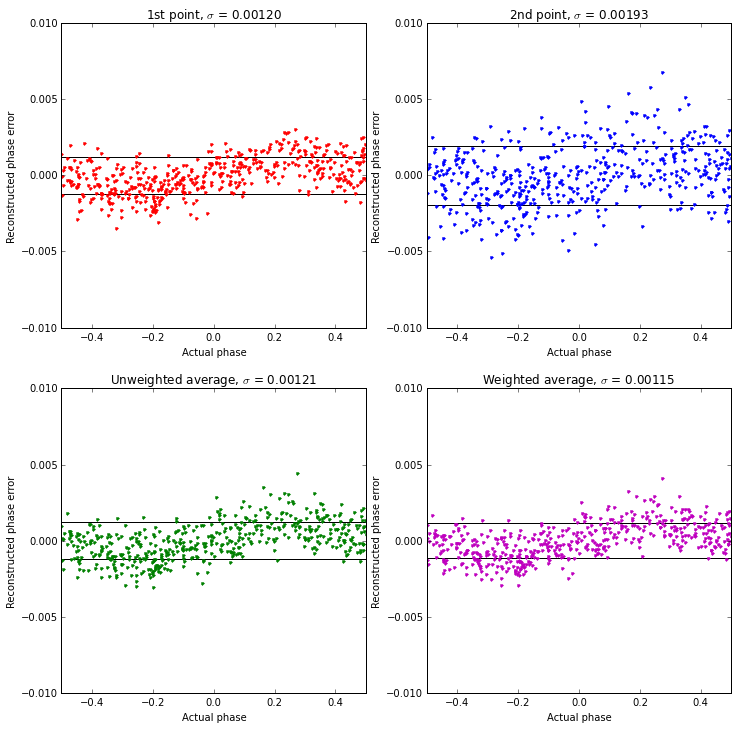

In [7]:
### Implementation of CDAE algorithm

def find_zero_crossings(samples, trig, N):
    zdata = []
    
    for i in range(len(samples)):
        s = samples[i]
        if np.abs(s) > trig:
            break

    for i in range(i, len(samples)-1):
        s1 = samples[i]
        s2 = samples[i+1]
        
        if s2 == 0:
            zdata.append(i)
            zdata.append(s2-s1)
        
        elif (s1 < 0 < s2) or (s1 > 0 > s2):
            zdata.append(i + s1 / (s1 - s2))
            zdata.append(s2-s1)

        if len(zdata) == 2*N:
            break

    assert len(zdata) == 2*N
    return zdata

zero_offsets = np.random.normal(scale=zero_drift_std, size=M)
zd = np.array([find_zero_crossings(FILT_S[i,:] + zero_offsets[i], 100, 2) for i in range(FILT_S.shape[0])])

# CDAE statistics data
zavg_diff = np.mean(zd[:, 2] - zd[:, 0])
zavg_del1 = np.mean(zd[:, 1])
zavg_del2 = np.mean(zd[:, 3])
print("zavg (diff, del1, del2): %f %+f %+f" % (zavg_diff, zavg_del1, zavg_del2))

zw = zd[:, 0] * zavg_del1 - zd[:, 2] * zavg_del2
zw = (zw + zavg_diff * 0.5 * (zavg_del1 + zavg_del2)) / (zavg_del1 - zavg_del2)
R = np.vstack([zd[:,0], zd[:,2], (zd[:,0] + zd[:,2]) * 0.5, zw]).T / oversampling

plt.figure(figsize=(12, 12))

def plot_phase_phase(title, zz, color):
    if False:
        plt.plot(P - 0.5, zz - np.mean(zz), color + ".")
        plt.ylabel("Reconstructed phase")
    else:
        std = np.std(zz - P)
        mu = np.mean(zz - P)
        title += ", $\\sigma$ = %.5f" % std
        plt.plot([-0.6, +0.6], [std, std], "k-")
        plt.plot([-0.6, +0.6], [-std, -std], "k-")
        plt.plot(P % 1.0 - 0.5, zz - P - mu, color + ".")
        plt.ylabel("Reconstructed phase error")
        plt.ylim(-0.01, +0.01)
        plt.xlim(-0.5, +0.5)
    plt.xlabel("Actual phase")
    plt.title(title)

plt.subplot(2, 2, 1)
plot_phase_phase("1st point", R[:, 0], "r")

plt.subplot(2, 2, 2)
plot_phase_phase("2nd point", R[:, 1], "b")

plt.subplot(2, 2, 3)
plot_phase_phase("Unweighted average", R[:, 2], "g")

plt.subplot(2, 2, 4)
plot_phase_phase("Weighted average", R[:, 3], "m")

Amplitude of sinusoidal phase error: 0.001033
Stddev of uncorrected and corrected phase error: 0.001151 0.000885


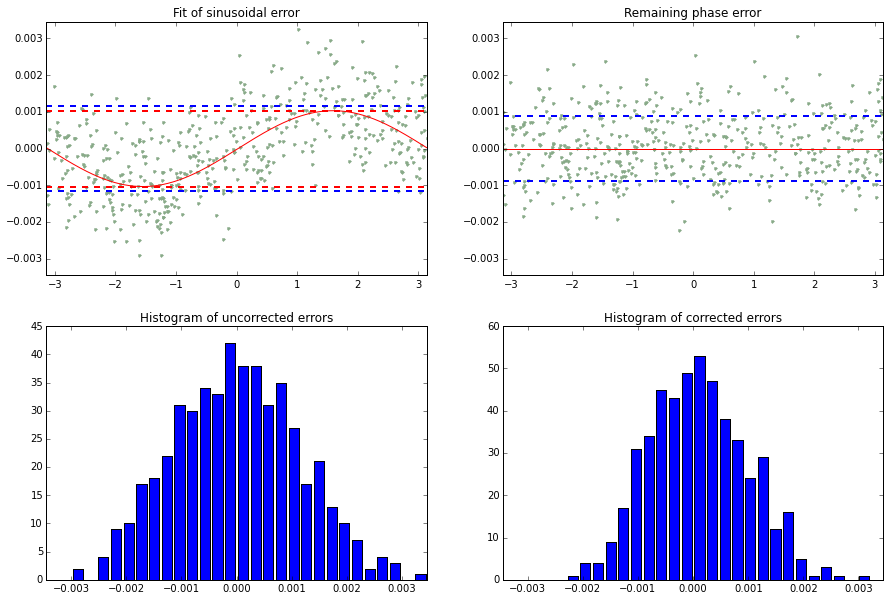

In [8]:
# Determine sinusoidal phase error

PX = (P % 1.0 - 0.5) * 2 * np.pi
PY = zw / oversampling - P
PY -= np.mean(PY)

A = np.zeros((M, 2))
A[:, 0] = np.sin(PX)
A[:, 1] = np.cos(PX)
k0, k1 = np.linalg.solve(A.T.dot(A), A.T.dot(PY))
k = np.sqrt(k0*k0 + k1*k1)

PC = PY - (k0 * np.sin(PX) + k1 * np.cos(PX))

print("Amplitude of sinusoidal phase error: %f" % k)

s_uncorr = np.std(PY)
s_corr = np.std(PC)

print("Stddev of uncorrected and corrected phase error: %f %f" % (s_uncorr, s_corr))

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.title('Fit of sinusoidal error')
plt.plot(PX, PY, ".", color="#88aa88")

t = np.arange(-np.pi, +np.pi, 0.01)
plt.plot(t, k0 * np.sin(t) + k1 * np.cos(t), "r-")

plt.plot([-np.pi, +np.pi], [+k, +k], "r--", lw=2)
plt.plot([-np.pi, +np.pi], [-k, -k], "r--", lw=2)
plt.plot([-np.pi, +np.pi], [+s_uncorr, +s_uncorr], "b--", lw=2)
plt.plot([-np.pi, +np.pi], [-s_uncorr, -s_uncorr], "b--", lw=2)
plt.ylim(-3*s_uncorr, +3*s_uncorr)
plt.xlim(-np.pi, +np.pi)

plt.subplot(2, 2, 2)
plt.title('Remaining phase error')
plt.plot(PX, PC, ".", color="#88aa88")
plt.plot([-np.pi, +np.pi], [0, 0], "r-")
plt.plot([-np.pi, +np.pi], [+s_corr, +s_corr], "b--", lw=2)
plt.plot([-np.pi, +np.pi], [-s_corr, -s_corr], "b--", lw=2)
plt.ylim(-3*s_uncorr, +3*s_uncorr)
plt.xlim(-np.pi, +np.pi)

plt.subplot(2, 2, 3)
plt.title('Histogram of uncorrected errors')
bins, edges = np.histogram(PY, bins=30, range=(-3*s_uncorr, +3*s_uncorr))
plt.bar((edges[:-1] + edges[1:]) / 2, bins, align='center', width=0.8*(edges[1]-edges[0]))
plt.xlim(-3*s_uncorr, +3*s_uncorr)

plt.subplot(2, 2, 4)
plt.title('Histogram of corrected errors')
bins, edges = np.histogram(PC, bins=30, range=(-3*s_uncorr, +3*s_uncorr))
plt.bar((edges[:-1] + edges[1:]) / 2, bins, align='center', width=0.8*(edges[1]-edges[0]))
plt.xlim(-3*s_uncorr, +3*s_uncorr);

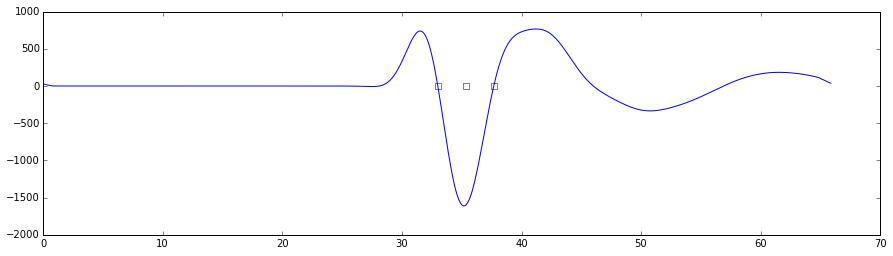

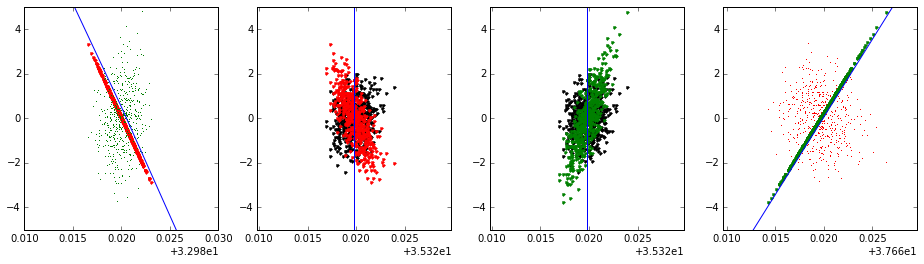

In [9]:
# Plot model and corrections from CDAE statistics data

p1 = zd[:,0] - oversampling * P
p2 = zd[:,2] - oversampling * P
p = 0.5 * np.mean(p1 + p2)

y1 = (p1 - p + zavg_diff * 0.5) * zavg_del1
y2 = (p2 - p - zavg_diff * 0.5) * zavg_del2
y = (y1 + y2) * 0.5

pp = (p1*zavg_del1 - p2*zavg_del2 + zavg_diff * 0.5 * (zavg_del1 + zavg_del2)) / (zavg_del1 - zavg_del2)

def plot_stuff(x_center, y_vals):
    plt.plot(p1 / oversampling, y1, "r." if y1 is y_vals else "r,")
    plt.plot(p1 / oversampling, y2, "g." if y2 is y_vals else "g,")

    plt.plot(p2 / oversampling, y1, "r." if y1 is y_vals else "r,")
    plt.plot(p2 / oversampling, y2, "g." if y2 is y_vals else "g,")

    if y1 is y_vals:
        plt.plot(pp / oversampling, y, "k.")
        plt.plot(pp / oversampling, y1, "r.")

    if y2 is y_vals:
        plt.plot(pp / oversampling, y, "k.")
        plt.plot(pp / oversampling, y2, "g.")

    plt.plot([p / oversampling, p / oversampling], [-25, +25], "b")
    plt.plot(filt_fine_x, filt_fine_y, "b")
    
    if x_center is not None:
        plt.xlim(x_center - 0.01, x_center + 0.01)
        plt.ylim(-5, 5)

    
plt.figure(figsize=(15, 4))

plt.plot(filt_fine_x, filt_fine_y, "b")
plt.plot([np.mean(ps) / oversampling for ps in [p1, pp, p2]], [0, 0, 0], "ks", fillstyle="none")


plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plot_stuff(np.mean(p1) / oversampling, y1)

plt.subplot(1, 4, 2)
plot_stuff(np.mean(pp) / oversampling, y1)

plt.subplot(1, 4, 3)
plot_stuff(np.mean(pp) / oversampling, y2)

plt.subplot(1, 4, 4)
plot_stuff(np.mean(p2) / oversampling, y2)

In [10]:
# Write output files with test data

with open("cdae_dbg_config.txt", "w") as f:
    print("fir_h %s" % " ".join(["%e" % v for v in fir_h]), file=f)
    for i in range(iir_sos.shape[0]):
        print("iir_sos %s" % " ".join(["%e" % v for v in iir_sos[i,:]]), file=f)

np.savetxt("cdae_dbg_samples.txt", S)
np.savetxt("cdae_dbg_phases.txt", P)
np.savetxt("cdae_dbg_resampled.txt", INTERP_S)
np.savetxt("cdae_dbg_filtered.txt", FILT_S)
np.savetxt("cdae_dbg_results.txt", R)